### **Importing dataset from kaggle**

In [1]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d pratik2901/multiclass-weather-dataset

 82% 75.0M/91.4M [00:00<00:00, 71.6MB/s]
100% 91.4M/91.4M [00:00<00:00, 104MB/s] 


In [7]:
!unzip '/content/multiclass-weather-dataset.zip'

Archive:  /content/multiclass-weather-dataset.zip
  inflating: Multi-class Weather Dataset/Cloudy/cloudy1.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy10.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy100.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy101.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy102.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy103.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy104.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy105.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy106.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy107.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy108.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy109.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy11.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy110.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy111.


---

### **Importing required libraries**

In [8]:
import os
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
base_dir = '/content/Multi-class Weather Dataset'

In [10]:
folder = os.listdir(base_dir)
folder

['Rain', 'Shine', 'Cloudy', 'Sunrise']

### **Importing `ImageDataGenerator` for image augmentation**

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
os.getcwd()

'/content'

In [13]:
os.mkdir("train_augmented_dir")      # directory for storing augmented train images
os.mkdir("val_augmented_dir")        # directory for storing augmented validation images 

In [14]:
train_gen = ImageDataGenerator(rescale=1/255,width_shift_range=0.2,
                               height_shift_range = 0.2,
                               shear_range=0.2,
                               zoom_range = 0.2,
                               brightness_range = (0.3,0.1),
                               horizontal_flip = True,
                              vertical_flip = True,
                              validation_split = 0.2)


In [15]:
# contains training data
train_data = train_gen.flow_from_directory(directory = base_dir,
                                           target_size = (250,250),
                                           batch_size = 32,
                                           shuffle = True,
                                           class_mode = 'categorical',
                                           save_to_dir = 'train_augmented_dir',
                                           save_format = 'png',
                                           subset = 'training')



# contains validation data
val_data = train_gen.flow_from_directory(directory = base_dir,
                                           target_size = (250,250),
                                           batch_size = 32,
                                           shuffle = True,
                                           class_mode = 'categorical',
                                           save_to_dir = 'val_augmented_dir',
                                           save_format = 'png',
                                           subset = 'validation')


Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


### **Checking indexes for classes**

In [16]:
train_data.class_indices

{'Cloudy': 0, 'Rain': 1, 'Shine': 2, 'Sunrise': 3}

In [17]:
val_data.class_indices

{'Cloudy': 0, 'Rain': 1, 'Shine': 2, 'Sunrise': 3}

**Creating labels**

In [18]:
labels  = train_data.class_indices
labels = dict((value,key) for key, value in labels.items())

labels

{0: 'Cloudy', 1: 'Rain', 2: 'Shine', 3: 'Sunrise'}

---

### **CNN Model**

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [20]:
TOTAL_CLASSES = 4

In [21]:
input = Input(shape = (250,250,3))

x = Conv2D(32, kernel_size = (3,3), activation = 'relu')(input)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Conv2D(64, kernel_size = (3,3), activation = 'relu')(x)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Conv2D(128, kernel_size = (3,3), activation = 'relu')(x)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Flatten()(x)    # flattening data

x = Dropout(0.4)(x)
x = Dense(128, activation = 'relu')(x)
output = Dense(TOTAL_CLASSES, activation = 'softmax', name = "Output")(x)

**Creating object of `Model`**

In [22]:
model = Model(input , output)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 128)       0     

### **Plotting model**

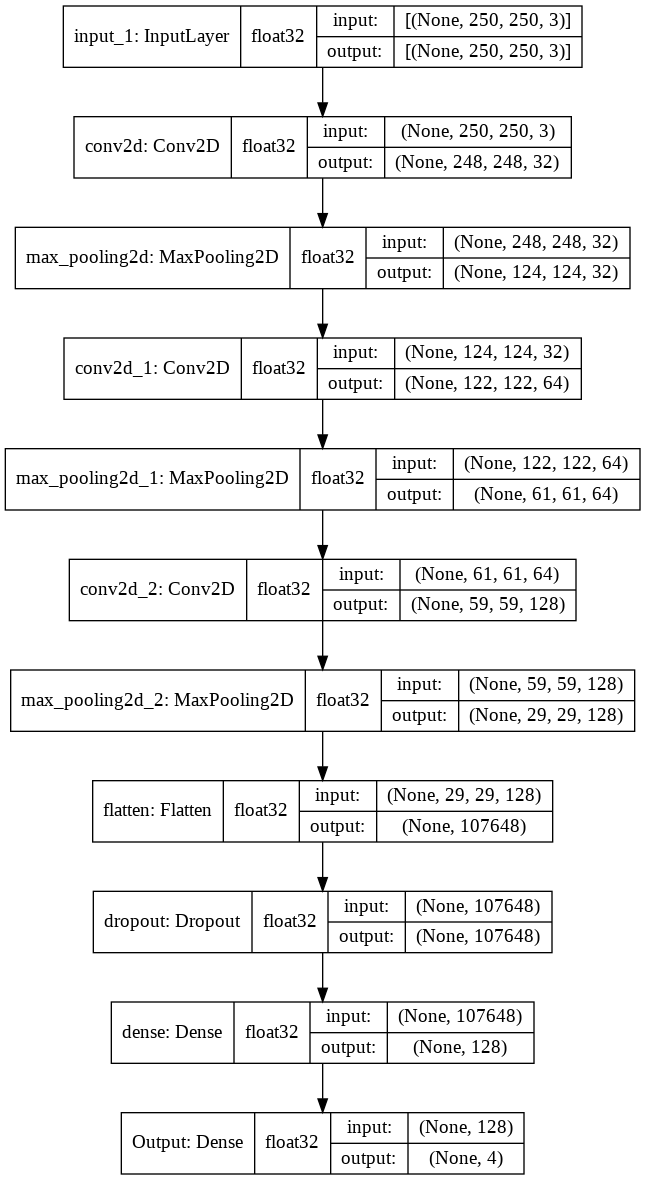

In [24]:
plot_model(model, to_file='model.png',show_shapes=True, show_dtype=True, show_layer_names=True)

### **Compiling model**

In [25]:
model.compile(optimizer = Adam(lr=0.001),
              loss = 'categorical_crossentropy',
              metrics='accuracy')

### **Defining Callbacks**

In [26]:
class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('accuracy') > 0.83) and (logs.get('val_accuracy') > 0.83)):
      print("\nReached desired accuracy and loss, So cancelling training!")
      self.model.stop_training = True


# Creating object of myCallback
callbacks = myCallback()

### **Training Model**

In [27]:
%time result = model.fit_generator(train_data, validation_data = val_data, epochs = 20, shuffle = True, callbacks = [callbacks])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
29/29 [==============================] - 76s 2s/step - loss: 1.0892 - accuracy: 0.5039 - val_loss: 0.8216 - val_accuracy: 0.7009
Epoch 2/20
29/29 [==============================] - 43s 1s/step - loss: 0.6699 - accuracy: 0.7372 - val_loss: 0.8235 - val_accuracy: 0.6920
Epoch 3/20
29/29 [==============================] - 44s 2s/step - loss: 0.5184 - accuracy: 0.7904 - val_loss: 0.7648 - val_accuracy: 0.6786
Epoch 4/20
29/29 [==============================] - 43s 2s/step - loss: 0.5406 - accuracy: 0.7894 - val_loss: 0.5992 - val_accuracy: 0.7366
Epoch 5/20
29/29 [==============================] - 43s 2s/step - loss: 0.4210 - accuracy: 0.8369 - val_loss: 0.6106 - val_accuracy: 0.7768
Epoch 6/20
29/29 [==============================] - 43s 2s/step - loss: 0.4021 - accuracy: 0.8266 - val_loss: 0.6194 - val_accuracy: 0.7946
Epoch 7/20
29/29 [==============================] - 43s 1s/step - loss: 0.3442 - accuracy: 0.8729 - val_loss: 0.5391 - val_accuracy: 0.7946
Epoch 8/20
29/29 [==

In [28]:
logs = pd.DataFrame(result.history, index=[i for i in range(1,9)])
logs

,loss,accuracy,val_loss,val_accuracy
1,0.890940,0.619312,0.821588,0.700893
2,0.636988,0.749168,0.823524,0.691964
3,0.533640,0.794673,0.764820,0.678571
4,0.493036,0.816870,0.599166,0.736607
5,0.418479,0.853496,0.610609,0.776786
6,0.405875,0.832408,0.619380,0.794643
7,0.387246,0.859046,0.539139,0.794643
8,0.443355,0.841287,0.451458,0.830357


In [29]:
epoch = [i for i in range(1,len(logs['accuracy'])+1)]
epoch

[1, 2, 3, 4, 5, 6, 7, 8]

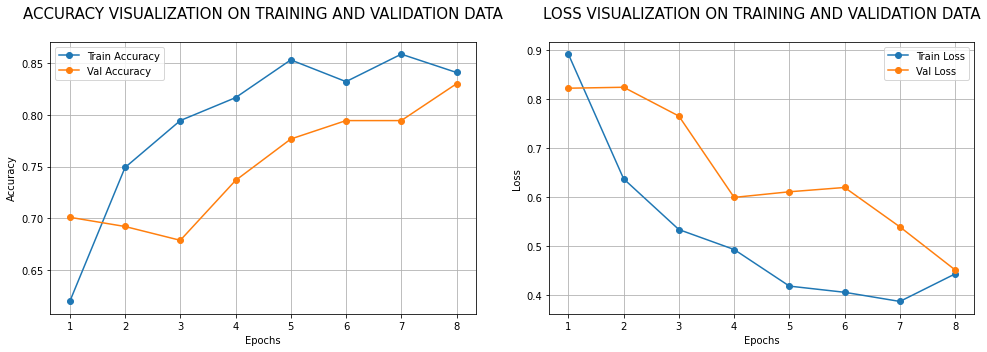

In [30]:
plt.figure(figsize=(14,5))     # setting size of figure

# first_model

plt.subplot(1,2,1)

plt.plot(epoch, logs['accuracy'], label='Train Accuracy', marker='o')
plt.plot(epoch,logs['val_accuracy'], label='Val Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("ACCURACY VISUALIZATION ON TRAINING AND VALIDATION DATA\n", size=15)
plt.legend()
plt.grid()
plt.tight_layout()


plt.subplot(1,2,2)

plt.plot(epoch, logs['loss'], label='Train Loss', marker='o')
plt.plot(epoch,logs['val_loss'], label='Val Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("LOSS VISUALIZATION ON TRAINING AND VALIDATION DATA\n", size=15)
plt.grid()


**Labels**

In [31]:
pd.DataFrame(train_data.class_indices,
             index = ['Class'])


,Cloudy,Rain,Shine,Sunrise
Class,0,1,2,3


### **Prediction from model**

**Importing `load_img`, `img_to_array`**

In [32]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

**Function that loads image**

In [33]:
def loading_img(img_path):
  img = load_img(img_path, target_size=(250,250))
  
  return img

### **Preprocessing**
- Image to array
- Normalizing
- Expanding dimension

**Function that preprocess image**

In [34]:
def preprocess_image(img):
  img = img_to_array(img)
  img = img / 255.0
  img = np.expand_dims(img, axis = 0)

  return img

**Function that predict image and and classify its label**

In [35]:
def prediction(img):
  plt.title("IMAGE")
  plt.axis('off')
  plt.imshow(img.reshape(250,250,3))

  pred = model.predict(img)
  high_acc_index = pred.argmax()     # returns index number of accuracy which is higher then others
  pred_class = labels[high_acc_index]

  print(f"Prediction Accuracy: {pred.max()}")
  print(f'Classified: {pred_class}')

In [ ]:
# --------------------------------------

In [36]:
image_path = '/content/Multi-class Weather Dataset/Rain/rain200.jpg'

In [37]:
# Loading Image
img_1 = loading_img(image_path)

# Preprocess Image
preprocessed_img = preprocess_image(img_1)

Prediction Accuracy: 1.0
Classified: Rain


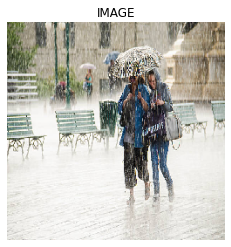

In [38]:
prediction(preprocessed_img)

---

Prediction Accuracy: 1.0
Classified: Sunrise


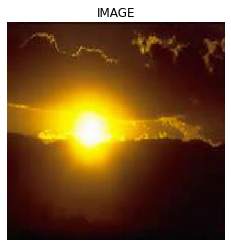

In [39]:
image_path = "/content/Multi-class Weather Dataset/Sunrise/sunrise242.jpg"

# loading image
img_2 = loading_img(image_path)

# preprocess image
img_2 = preprocess_image(img_2)

# model prediction
prediction(img_2)

---

Prediction Accuracy: 0.9986225366592407
Classified: Shine


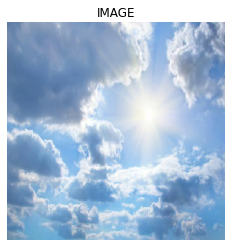

In [40]:
image_path = "/content/Multi-class Weather Dataset/Shine/shine69.jpg"

# loading image
img_3 = loading_img(image_path)

# preprocess image
img_3 = preprocess_image(img_3)

# model prediction
prediction(img_3)

---

Prediction Accuracy: 0.99491286277771
Classified: Cloudy


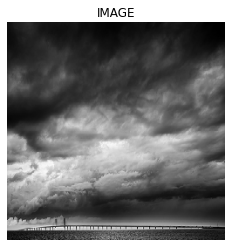

In [41]:
# setting image path
image_path = "/content/Multi-class Weather Dataset/Cloudy/cloudy58.jpg"

# loading image
img_4 = loading_img(image_path)

# preprocess image
img_4 = preprocess_image(img_4)

# model prediction
prediction(img_4)

---

#### **Now loading another image which I download from google for model prediction**

In [43]:
from google.colab import files

files.upload()

Saving rain.jpeg to rain.jpeg


{'rain.jpeg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x13\x13\x12\x15\x13\x13\x13\x16\x15\x15\x17\x18\x18\x1a\x18\x18\x18\x17\x1a\x1a\x1a\x16\x1d\x18\x1a\x1d\x1a\x1b\x18\x1a\x18\x18\x1d( \x18\x1a\'\x1b\x1b\x1a"1!%)+...\x1d\x1f383-7(-.+\x01\n\n\n\x0e\r\x0e\x15\x10\x10\x15+\x1d\x15\x1d+++--+--++-+--+-----+++-------+++-----+74+-7++--+7\xff\xc0\x00\x11\x08\x00\xb7\x01\x13\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x05\x02\x03\x06\x00\x01\x07\x08\xff\xc4\x00>\x10\x00\x01\x03\x02\x03\x05\x06\x05\x03\x03\x02\x05\x05\x00\x00\x00\x01\x00\x02\x11\x03!\x041A\x05\x12Qaq"\x81\x91\xa1\xb1\xf0\x06\x132\xc1\xd1B\xe1\xf1\x07\x14R#\xb2\x15Cb\x92\xa2$3S\x82\xc2\xff\xc4\x00\x17\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\xff\xc4\x00\x1c\x11\x01\x01\x01\x00\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x11\x02!1A\x03

Prediction Accuracy: 0.9999476671218872
Classified: Rain


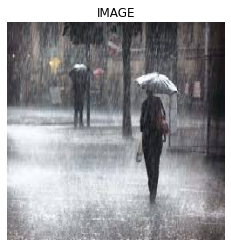

In [44]:

image_path = "/content/rain.jpeg"

img = loading_img(image_path)

img = preprocess_image(img)

prediction(img)

**So, model predict right with 99.99% of accuracy and classified image as Rain**

---

### **Saving Model**

In [45]:
model.save("weather_classifier.h5")

### **Now evaluating model on validation data**

In [ ]:
loss, acc = model.evaluate(val_data)

print(f"Validation accuracy is: {np.round(acc,3) * 100} %")
print(f"Validation loss is: {np.round(loss,3) * 100} %")

7/7 [==============================] - 10s 1s/step - loss: 0.5772 - accuracy: 0.8259
Validation accuracy is: 82.6 %
Validation loss is: 57.699999999999996 %
